In [1]:
# ===============================================================
# QUANTUM STEERING - COMPLETE SCRIPT
# ===============================================================

import numpy as np
import qutip as qt
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time

# Enhanced plotting
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

In [2]:
# ===============================================================
# CORE QUANTUM FUNCTIONS
# ===============================================================

def generate_hamiltonians(a_values, b_values):
    """Generate Hamiltonian dictionary"""
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    """Time evolution under Hamiltonian H"""
    return qt.sesolve(H, psi0, tlist).states


In [3]:
# ===============================================================
# CONSTRAINT SYSTEM
# ===============================================================

def _J_block(J, i, j):
    """Extract (i,j)-block from Choi matrix"""
    return J[2*i:2*(i+1), 2*j:2*(j+1)]

def _phi_of_rho_from_choi(J, rho):
    """Φ(ρ) = ∑ᵢⱼ ρ[i,j] * J_block[i,j]"""
    return sum(rho[i, j] * _J_block(J, i, j) for i in range(2) for j in range(2))

def _tp_constraints(J, relaxation_params):
    """Trace preservation constraints"""
    cons = [J >> 0]
    tp_tolerance = relaxation_params.get('tp_tolerance', 1e-8)
    
    for i in range(2):
        for j in range(2):
            if i == j:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j)) - 1.0) <= tp_tolerance)
            else:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j))) <= tp_tolerance)
    return cons

def _coupled_constraints(J, H, rho, relaxation_params, impose_covariance, impose_passivity):
    """Properly coupled constraints"""
    constraints = []
    
    Hm = H.full()
    I2 = np.eye(2)
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    
    # Extract tolerances
    covariance_tolerance = relaxation_params.get('covariance_tolerance', 0.01)
    passivity_tolerance = relaxation_params.get('passivity_tolerance', 0.01)
    
    # Get output state and initial energy
    Phi_rho = _phi_of_rho_from_choi(J, rho)
    initial_energy = float(np.real(np.trace(Hm @ rho)))
    
    # Store initial_energy for later use
    constraint_info = {'initial_energy': initial_energy}
    
    # Constraint coupling
    if impose_covariance and impose_passivity:
        # When both are active, scale tolerances based on each other
        effective_covariance = covariance_tolerance * (1 + passivity_tolerance * 5)
        effective_passivity = passivity_tolerance * (1 + covariance_tolerance * 5)
        
        covariance_constraint = cp.norm(G @ J - J @ G, 2) <= effective_covariance
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        
        constraints.extend([covariance_constraint, passivity_constraint])
        
    elif impose_covariance:
        # Only covariance
        constraints.append(cp.norm(G @ J - J @ G, 2) <= covariance_tolerance)
        
    elif impose_passivity:
        # Only passivity
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + passivity_tolerance
        constraints.append(passivity_constraint)
    
    return constraints, Phi_rho, constraint_info

def _state_distance_constraint(Phi_rho, rho, relaxation_params):
    """State distance constraint"""
    state_distance_tolerance = relaxation_params.get('state_distance_tolerance', 0.02)
    step_size = relaxation_params.get('step_size', 0.1)
    eta = relaxation_params.get('eta', 0.05)
    
    base_tolerance = eta * step_size * 0.2
    total_tolerance = base_tolerance + state_distance_tolerance
    
    return [cp.norm(Phi_rho - rho, "nuc") <= 2.0 * total_tolerance]

In [4]:
def fidelity_sdp_step(rho_qobj, sigma_qobj, H_qobj, **kwargs):
    """SDP step for quantum steering"""
    impose_covariance = kwargs.get('impose_covariance', True)
    impose_passivity = kwargs.get('impose_passivity', True)
    step_size = kwargs.get('step_size', 0.1)
    eta = kwargs.get('eta', 0.05)
    verbose = kwargs.get('verbose', False)
    relaxation_params = kwargs.get('relaxation_params', {})
    
    relaxation_params = relaxation_params.copy()
    relaxation_params.update({'step_size': step_size, 'eta': eta})
    
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj

    # SDP variables
    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    # Build constraints
    constraints = _tp_constraints(J, relaxation_params)
    
    # Get constraint info including initial_energy
    coupled_constraints, Phi_rho, constraint_info = _coupled_constraints(
        J, H, rho, relaxation_params, impose_covariance, impose_passivity
    )
    constraints.extend(coupled_constraints)

    # Output state constraints
    constraints.extend([
        Phi_rho >> 0, 
        cp.trace(Phi_rho) == 1
    ])
    
    # State evolution constraint
    constraints.extend(_state_distance_constraint(Phi_rho, rho, relaxation_params))

    # Fidelity constraints
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints.extend([
        block >> 0, 
        cp.real(cp.trace(W)) >= t
    ])

    # Solve SDP
    prob = cp.Problem(cp.Maximize(t), constraints)
    
    try:
        prob.solve(solver=cp.SCS, eps_abs=1e-6, eps_rel=1e-6, max_iters=50000, verbose=verbose)
        status = prob.status
        sqrtF = float(prob.value) if prob.value is not None else 0.0
    except Exception as e:
        status = f"Error: {e}"
        sqrtF = 0.0

    # Prepare results
    resulting_state = qt.Qobj(Phi_rho.value) if Phi_rho.value is not None else None
    
    # Calculate constraint violations
    violations = {}
    for i, constraint in enumerate(constraints):
        if hasattr(constraint, 'violation'):
            try:
                violations[f'constraint_{i}'] = float(constraint.violation())
            except:
                violations[f'constraint_{i}'] = np.nan
    
    # Calculate actual constraint violations with proper energy tracking
    if J.value is not None:
        Hm = H.full()
        I2 = np.eye(2)
        G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
        
        actual_covariance = np.linalg.norm(G @ J.value - J.value @ G, 2)
        violations['actual_covariance'] = actual_covariance
        
        if Phi_rho.value is not None:
            final_energy = np.real(np.trace(Hm @ Phi_rho.value))
            # Use stored initial_energy from constraint_info
            actual_energy_change = final_energy - constraint_info['initial_energy']
            violations['actual_energy_change'] = actual_energy_change
    
    return {
        "status": status,
        "sqrtF": sqrtF,
        "fidelity": sqrtF**2,
        "resulting_state": resulting_state,
        "J": J.value.copy() if hasattr(J, 'value') and J.value is not None else None,
        "constraint_violations": violations
    }

In [5]:
# %%
# ===============================================================
# PROGRESS TRACKING
# ===============================================================

class ProgressTracker:
    def __init__(self, total, desc=""):
        self.total = total
        self.desc = desc
        self.start_time = time.time()
        self.current = 0
        self.print_progress(0)
    
    def update(self, n=1):
        self.current += n
        self.print_progress(self.current)
    
    def print_progress(self, current):
        elapsed = time.time() - self.start_time
        percent = (current / self.total) * 100
        eta = (elapsed / current) * (self.total - current) if current > 0 else 0
        
        bar_length = 30
        filled_length = int(bar_length * current // self.total)
        bar = '█' * filled_length + '─' * (bar_length - filled_length)
        
        print(f'\r{self.desc} |{bar}| {current}/{self.total} ({percent:.1f}%) | ETA: {eta:.1f}s', 
              end='', flush=True)
    
    def close(self):
        elapsed = time.time() - self.start_time
        print(f'\r{self.desc} | Completed in {elapsed:.1f}s' + ' ' * 50)

def track_progress(iterable, desc=""):
    """Generator with progress tracking"""
    total = len(iterable)
    tracker = ProgressTracker(total, desc)
    
    for i, item in enumerate(iterable):
        yield item
        tracker.update(1)
    
    tracker.close()

In [6]:
# %%
# ===============================================================
# CONSTRAINT OPTIMIZATION
# ===============================================================

def test_steering_parameters(H, initial_states, target_state, tlist, config):
    """Test steering with given parameters"""
    steered_states = [qt.ket2dm(list(initial_states.values())[0])]
    metrics = {
        'time': [0.0],
        'fidelity': [float(np.real(qt.fidelity(steered_states[0], target_state)))],
        'sdp_fidelity': [],
        'covariance_violations': [],
        'energy_changes': []
    }
    
    dt = tlist[1] - tlist[0] if len(tlist) > 1 else 0.1
    
    # Test just a few steps for speed
    test_steps = min(3, len(tlist))
    
    for i in range(test_steps):
        result = fidelity_sdp_step(
            steered_states[-1], target_state, H,
            step_size=dt,
            **config
        )
        
        metrics['time'].append(tlist[i] if i < len(tlist) else tlist[-1])
        metrics['sdp_fidelity'].append(result['fidelity'])
        
        # Collect constraint diagnostics
        if 'actual_covariance' in result['constraint_violations']:
            metrics['covariance_violations'].append(result['constraint_violations']['actual_covariance'])
        if 'actual_energy_change' in result['constraint_violations']:
            metrics['energy_changes'].append(result['constraint_violations']['actual_energy_change'])
        
        if result['resulting_state'] is not None:
            steered_states.append(result['resulting_state'])
            metrics['fidelity'].append(result['fidelity'])
        else:
            break
    
    return {
        'steered_states': steered_states,
        'metrics': metrics,
        'final_fidelity': metrics['fidelity'][-1] if metrics['fidelity'] else 0.0
    }

def evaluate_performance(trajectory_data, param_name, param_value):
    """Evaluate steering performance"""
    fidelity_curve = trajectory_data['metrics']['fidelity']
    final_fidelity = trajectory_data['final_fidelity']
    
    # Calculate curve quality
    if len(fidelity_curve) > 2:
        gradients = np.diff(fidelity_curve)
        smoothness = 1.0 / (1.0 + np.std(gradients))
    else:
        smoothness = 0.0
    
    # Performance score
    performance_score = final_fidelity * smoothness
    
    return {
        'final_fidelity': final_fidelity,
        'smoothness': smoothness,
        'performance_score': performance_score,
        'param_name': param_name,
        'param_value': param_value
    }

def optimize_constraints(H, initial_states, target_state, tlist, base_config, param_grid):
    """Find optimal constraint parameters"""
    
    print("🧪 Starting constraint optimization...")
    optimization_results = {}
    
    for param_name, param_values in param_grid.items():
        print(f"🔧 Optimizing {param_name}...")
        param_results = {}
        
        for param_value in param_values:
            # Create test configuration
            test_relaxation = base_config.get('relaxation_params', {}).copy()
            test_relaxation[param_name] = param_value
            test_config = base_config.copy()
            test_config['relaxation_params'] = test_relaxation
            
            # Test with representative state
            test_state_name = list(initial_states.keys())[0]
            test_state = initial_states[test_state_name]
            
            try:
                trajectory_data = test_steering_parameters(
                    H, {test_state_name: test_state}, target_state, tlist, test_config
                )
                
                if trajectory_data:
                    performance = evaluate_performance(trajectory_data, param_name, param_value)
                    param_results[param_value] = performance
                    
                    print(f"   {param_name}={param_value:.4f} -> "
                          f"Fidelity: {performance['final_fidelity']:.4f}, "
                          f"Smoothness: {performance['smoothness']:.4f}")
                else:
                    print(f"   {param_name}={param_value:.4f} -> Failed")
                    
            except Exception as e:
                print(f"   {param_name}={param_value:.4f} -> Error: {e}")
        
        optimization_results[param_name] = param_results
    
    # Find optimal parameters
    best_params = {}
    for param_name, param_results in optimization_results.items():
        best_score = -1
        best_value = None
        
        for param_value, results in param_results.items():
            if results['performance_score'] > best_score:
                best_score = results['performance_score']
                best_value = param_value
        
        if best_value is not None:
            best_params[param_name] = best_value
            print(f"✅ Optimal {param_name}: {best_value:.4f}")
    
    return optimization_results, best_params

In [7]:
# %%
# ===============================================================
# QUANTUM STEERING EXPERIMENT
# ===============================================================

def initialize_metrics(initial_state, target_state, H):
    """Initialize tracking metrics"""
    return {
        'time': [0.0],
        'fidelity': [float(np.real(qt.fidelity(initial_state, target_state)))],
        'purity': [float(np.real(initial_state.purity()))],
        'energy': [float(np.real(qt.expect(H, initial_state)))],
        'coherence': [float(np.real(abs(initial_state.full()[0,1])))],
        'bloch_coords': [[float(np.real(qt.expect(qt.sigmax(), initial_state))),
                         float(np.real(qt.expect(qt.sigmay(), initial_state))),
                         float(np.real(qt.expect(qt.sigmaz(), initial_state)))]],
        'sdp_fidelity': []
    }

def update_metrics(metrics, state, target_state, H):
    """Update tracking metrics"""
    metrics['fidelity'].append(float(np.real(qt.fidelity(state, target_state))))
    metrics['purity'].append(float(np.real(state.purity())))
    metrics['energy'].append(float(np.real(qt.expect(H, state))))
    metrics['coherence'].append(float(np.real(abs(state.full()[0,1]))))
    metrics['bloch_coords'].append([
        float(np.real(qt.expect(qt.sigmax(), state))),
        float(np.real(qt.expect(qt.sigmay(), state))),
        float(np.real(qt.expect(qt.sigmaz(), state)))
    ])

def run_steering_experiment(H, initial_states, target_state, tlist, config):
    """Run steering experiment for single Hamiltonian"""
    
    dt = tlist[1] - tlist[0] if len(tlist) > 1 else 0.1
    trajectory_data = {}
    
    for state_name, initial_state in track_progress(initial_states.items(), f"Steering states"):
        # Initial state
        rho_steered = qt.ket2dm(initial_state)
        steered_states = [rho_steered]
        
        # Initialize metrics
        metrics = initialize_metrics(rho_steered, target_state, H)
        
        for i, t in enumerate(tlist):
            # Apply SDP steering step
            result = fidelity_sdp_step(
                rho_steered, target_state, H,
                step_size=dt,
                **config
            )
            
            metrics['time'].append(t)
            metrics['sdp_fidelity'].append(result['fidelity'])
            
            if result['resulting_state'] is not None:
                rho_steered = result['resulting_state']
            
            steered_states.append(rho_steered)
            
            # Update metrics
            update_metrics(metrics, rho_steered, target_state, H)
            
            # Early termination if fidelity plateaus
            if len(metrics['fidelity']) > 10:
                recent_fidelities = metrics['fidelity'][-5:]
                if np.std(recent_fidelities) < 1e-4 and recent_fidelities[-1] > 0.99:
                    break
        
        trajectory_data[state_name] = {
            'steered_states': steered_states,
            'metrics': metrics,
            'final_fidelity': float(np.real(metrics['fidelity'][-1])),
            'improvement': float(np.real(metrics['fidelity'][-1] - metrics['fidelity'][0]))
        }
    
    return trajectory_data

In [8]:
# ===============================================================
# SYMMETRY BREAKING ANALYSIS
# ===============================================================

def calculate_time_reversal_breaking(initial, final):
    """Calculate time reversal symmetry breaking"""
    fid_normal = qt.fidelity(initial, final)
    fid_time_rev = qt.fidelity(initial, qt.Qobj(final.full().conj()))
    return abs(fid_normal - fid_time_rev)

def calculate_parity_breaking(initial, final):
    """Calculate parity symmetry breaking"""
    sz = qt.sigmaz()
    fid_normal = qt.fidelity(initial, final)
    fid_parity = qt.fidelity(sz * initial * sz, sz * final * sz)
    return abs(fid_normal - fid_parity)

def calculate_phase_symmetry_breaking(initial, final):
    """Calculate phase symmetry breaking"""
    theta = np.pi/4
    U_phase = (-1j * theta * qt.sigmaz()).expm()
    fid_normal = qt.fidelity(initial, final)
    fid_phase = qt.fidelity(U_phase * initial * U_phase.dag(), 
                          U_phase * final * U_phase.dag())
    return abs(fid_normal - fid_phase)

def calculate_curve_quality(fidelity_curve):
    """Calculate fidelity curve quality metrics"""
    if len(fidelity_curve) > 2:
        gradients = np.diff(fidelity_curve)
        return {
            'smoothness': 1.0 / (1.0 + np.std(gradients)),
            'max_jump': np.max(np.abs(gradients))
        }
    else:
        return {'smoothness': 0.0, 'max_jump': 0.0}

def analyze_symmetry_breaking(trajectory_data, H, config):
    """Analyze symmetry breaking in quantum trajectories"""
    
    symmetry_metrics = {}
    relaxation_params = config.get('relaxation_params', {})
    
    for state_name, data in trajectory_data.items():
        states = data['steered_states']
        metrics = data['metrics']
        
        initial_state = states[0]
        final_state = states[-1]
        
        # Calculate symmetry breaking measures
        time_rev_breaking = calculate_time_reversal_breaking(initial_state, final_state)
        parity_breaking = calculate_parity_breaking(initial_state, final_state)
        phase_breaking = calculate_phase_symmetry_breaking(initial_state, final_state)
        
        # Resource dynamics
        coherence_change = float(np.real(abs(final_state.full()[0,1]) - abs(initial_state.full()[0,1])))
        energy_change = float(np.real(qt.expect(H, final_state) - qt.expect(H, initial_state)))
        
        # Curve quality
        fidelity_curve = metrics['fidelity'][:-1]
        curve_quality = calculate_curve_quality(fidelity_curve)
        
        symmetry_metrics[state_name] = {
            'time_reversal_breaking': float(np.real(time_rev_breaking)),
            'parity_breaking': float(np.real(parity_breaking)),
            'phase_symmetry_breaking': float(np.real(phase_breaking)),
            'coherence_change': coherence_change,
            'energy_change': energy_change,
            'final_fidelity': float(np.real(metrics['fidelity'][-1])),
            'curve_smoothness': curve_quality['smoothness'],
            'max_fidelity_jump': curve_quality['max_jump'],
            'constraint_strength': 1.0 / (1.0 + relaxation_params.get('passivity_tolerance', 0) + 
                                        relaxation_params.get('covariance_tolerance', 0)),
            'coherence_generated': coherence_change > 0,
            'energy_increased': energy_change > 0
        }
    
    return symmetry_metrics

In [9]:
# ===============================================================
# VISUALIZATION
# ===============================================================

def create_visualizations(all_results, symmetry_results, optimization_results):
    """Create comprehensive visualizations"""
    
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 3, figure=fig)
    
    # 1. Fidelity evolution
    ax1 = fig.add_subplot(gs[0, 0])
    plot_fidelity_evolution(ax1, all_results)
    
    # 2. Performance summary
    ax2 = fig.add_subplot(gs[0, 1])
    plot_performance_summary(ax2, all_results)
    
    # 3. Constraint optimization results
    ax3 = fig.add_subplot(gs[0, 2])
    plot_optimization_results(ax3, optimization_results)
    
    # 4. Symmetry breaking correlation
    ax4 = fig.add_subplot(gs[1, 0])
    plot_symmetry_correlation(ax4, symmetry_results)
    
    # 5. Resource dynamics
    ax5 = fig.add_subplot(gs[1, 1])
    plot_coherence_dynamics(ax5, all_results)
    
    # 6. Energy dynamics
    ax6 = fig.add_subplot(gs[1, 2])
    plot_energy_dynamics(ax6, all_results)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_fidelity_evolution(ax, all_results):
    """Plot fidelity evolution over time"""
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_results)))
    
    for idx, (H_name, trajectories) in enumerate(all_results.items()):
        for state_name, data in trajectories.items():
            color = colors[idx]
            times = data['metrics']['time'][:len(data['metrics']['fidelity'])-1]
            fidelities = data['metrics']['fidelity'][:-1]
            
            ax.plot(times, fidelities, color=color, alpha=0.7, linewidth=2,
                   label=f'{H_name}_{state_name}' if idx < 2 else "")
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Fidelity to Target')
    ax.set_title('Fidelity Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

def plot_performance_summary(ax, all_results):
    """Plot performance summary bar chart"""
    performance_data = []
    
    for H_name, trajectories in all_results.items():
        for state_name, data in trajectories.items():
            performance_data.append({
                'Case': f'{H_name}_{state_name}',
                'Final_Fidelity': data['final_fidelity'],
            })
    
    df = pd.DataFrame(performance_data)
    df_sorted = df.sort_values('Final_Fidelity', ascending=False)
    
    bars = ax.bar(range(len(df_sorted)), df_sorted['Final_Fidelity'],
                 color=plt.cm.plasma(np.linspace(0, 1, len(df_sorted))))
    
    ax.set_xticks(range(len(df_sorted)))
    ax.set_xticklabels(df_sorted['Case'], rotation=45, ha='right')
    ax.set_ylabel('Final Fidelity')
    ax.set_title('Performance Ranking')
    ax.grid(True, alpha=0.3)

def plot_optimization_results(ax, optimization_results):
    """Plot constraint optimization results"""
    for param_name, param_results in optimization_results.items():
        if param_results:  # Only plot if we have results
            param_values = list(param_results.keys())
            performances = [r['performance_score'] for r in param_results.values()]
            ax.plot(param_values, performances, 'o-', label=param_name, linewidth=2, markersize=4)
    
    ax.set_xlabel('Parameter Value')
    ax.set_ylabel('Performance Score')
    ax.set_title('Constraint Optimization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

def plot_symmetry_correlation(ax, symmetry_results):
    """Plot symmetry breaking vs performance"""
    symmetry_data = []
    
    for H_name, sym_metrics in symmetry_results.items():
        for state_name, metrics in sym_metrics.items():
            symmetry_data.append({
                'Symmetry_Breaking': metrics['time_reversal_breaking'],
                'Final_Fidelity': metrics['final_fidelity'],
            })
    
    if symmetry_data:
        df = pd.DataFrame(symmetry_data)
        scatter = ax.scatter(df['Symmetry_Breaking'], df['Final_Fidelity'],
                           c=range(len(df)), cmap='viridis', s=80)
        ax.set_xlabel('Symmetry Breaking')
        ax.set_ylabel('Final Fidelity')
        ax.set_title('Symmetry vs Performance')
        ax.grid(True, alpha=0.3)

def plot_coherence_dynamics(ax, all_results):
    """Plot coherence dynamics"""
    for H_name, trajectories in all_results.items():
        for state_name, data in trajectories.items():
            times = data['metrics']['time'][:len(data['metrics']['coherence'])-1]
            coherences = data['metrics']['coherence'][:-1]
            ax.plot(times, coherences, label=f'{H_name}_{state_name}', 
                   linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Coherence')
    ax.set_title('Coherence Dynamics')
    ax.legend()
    ax.grid(True, alpha=0.3)

def plot_energy_dynamics(ax, all_results):
    """Plot energy dynamics"""
    for H_name, trajectories in all_results.items():
        for state_name, data in trajectories.items():
            times = data['metrics']['time'][:len(data['metrics']['energy'])-1]
            energies = data['metrics']['energy'][:-1]
            ax.plot(times, energies, label=f'{H_name}_{state_name}', 
                   linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy')
    ax.set_title('Energy Dynamics')
    ax.legend()
    ax.grid(True, alpha=0.3)

In [10]:
# ===============================================================
# MAIN EXPERIMENT
# ===============================================================

def main():
    """Execute complete quantum steering experiment"""
    
    print("="*80)
    print("🔬 QUANTUM STEERING WITH PROPER CONSTRAINT COUPLING")
    print("="*80)
    
    # Experimental setup
    a_vals = np.array([-2.0, 0.0, 2.0])
    b_vals = np.array([-1.0, 0.0, 1.0])
    hamiltonians_dict = generate_hamiltonians(a_vals, b_vals)
    
    # Select test Hamiltonians
    test_hamiltonians = {
        'Strong_Z': hamiltonians_dict[(-2.0, 0.0)],
        'Strong_X': hamiltonians_dict[(0.0, 1.0)],
        'Mixed_Field': hamiltonians_dict[(-2.0, -1.0)],
    }
    
    # Initial states
    initial_states = {
        'superpos_plus': (qt.basis(2,0) + qt.basis(2,1)).unit(),
        'superpos_i': (qt.basis(2,0) + 1j*qt.basis(2,1)).unit(),
    }
    
    # Time grid
    tlist = np.linspace(0, 6, 40)
    
    # Base configuration
    base_config = {
        'impose_covariance': True,
        'impose_passivity': True,
        'eta': 0.05,
        'verbose': False,
        'relaxation_params': {
            'tp_tolerance': 1e-8,
            'covariance_tolerance': 0.01,
            'passivity_tolerance': 0.01,
            'state_distance_tolerance': 0.05,
        }
    }
    
    # Step 1: Constraint Optimization
    print("\n🎯 STEP 1: CONSTRAINT PARAMETER OPTIMIZATION")
    
    param_grid = {
        'passivity_tolerance': [0.001, 0.01, 0.1],
        'covariance_tolerance': [0.001, 0.01, 0.1],
        'state_distance_tolerance': [0.01, 0.05, 0.1],
    }
    
    # Use one Hamiltonian for optimization
    test_H = test_hamiltonians['Mixed_Field']
    evals, evecs = test_H.eigenstates(sort='low')
    target_state = qt.ket2dm(evecs[1])
    
    optimization_results, best_params = optimize_constraints(
        test_H, initial_states, target_state, tlist[:10], base_config, param_grid
    )
    
    # Step 2: Main Experiment
    print("\n🔬 STEP 2: MAIN QUANTUM STEERING EXPERIMENT")
    
    # Use optimized parameters or defaults if optimization failed
    if best_params:
        optimal_config = base_config.copy()
        optimal_config['relaxation_params'].update(best_params)
        print("✅ Using optimized constraint parameters:")
        for param, value in best_params.items():
            print(f"   {param}: {value}")
    else:
        optimal_config = base_config
        print("⚠️  Using default constraint parameters")
    
    # Run main experiment
    all_results = {}
    symmetry_results = {}
    
    for H_name, H in track_progress(test_hamiltonians.items(), "Hamiltonians"):
        print(f"\n📊 Analyzing {H_name}...")
        
        # Get target state
        evals, evecs = H.eigenstates(sort='low')
        target_state = qt.ket2dm(evecs[1])
        
        # Run steering
        trajectory_data = run_steering_experiment(
            H, initial_states, target_state, tlist, optimal_config
        )
        all_results[H_name] = trajectory_data
        
        # Analyze symmetry breaking
        symmetry_metrics = analyze_symmetry_breaking(trajectory_data, H, optimal_config)
        symmetry_results[H_name] = symmetry_metrics
    
    # Step 3: Visualization
    print("\n📊 STEP 3: CREATING VISUALIZATIONS")
    fig = create_visualizations(all_results, symmetry_results, optimization_results)
    
    # Performance summary
    total_trajectories = sum(len(trajs) for trajs in all_results.values())
    avg_fidelity = np.mean([data['final_fidelity'] for trajs in all_results.values() 
                          for data in trajs.values()])
    
    print(f"\n✅ EXPERIMENT COMPLETE!")
    print(f"📈 Performance Summary:")
    print(f"   • Total trajectories: {total_trajectories}")
    print(f"   • Average final fidelity: {avg_fidelity:.4f}")
    
    return all_results, symmetry_results, optimization_results



🔬 QUANTUM STEERING WITH PROPER CONSTRAINT COUPLING

🎯 STEP 1: CONSTRAINT PARAMETER OPTIMIZATION
🧪 Starting constraint optimization...
🔧 Optimizing passivity_tolerance...


/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   passivity_tolerance=0.0010 -> Fidelity: 0.2785, Smoothness: 0.8951
   passivity_tolerance=0.0100 -> Fidelity: 0.2912, Smoothness: 0.8951
   passivity_tolerance=0.1000 -> Fidelity: 0.4181, Smoothness: 0.8951
🔧 Optimizing covariance_tolerance...
   covariance_tolerance=0.0010 -> Fidelity: 0.2906, Smoothness: 0.8951
   covariance_tolerance=0.0100 -> Fidelity: 0.2912, Smoothness: 0.8951
   covariance_tolerance=0.1000 -> Fidelity: 0.2973, Smoothness: 0.8951
🔧 Optimizing state_distance_tolerance...
   state_distance_tolerance=0.0100 -> Fidelity: 0.2912, Smoothness: 0.8950
   state_distance_tolerance=0.0500 -> Fidelity: 0.2912, Smoothness: 0.8951
   state_distance_tolerance=0.1000 -> Fidelity: 0.2912, Smoothness: 0.8951
✅ Optimal passivity_tolerance: 0.1000
✅ Optimal covariance_tolerance: 0.1000
✅ Optimal state_distance_tolerance: 0.0500

🔬 STEP 2: MAIN QUANTUM STEERING EXPERIMENT
✅ Using optimized constraint parameters:
   passivity_tolerance: 0.1
   covariance_tolerance: 0.1
   state_dis

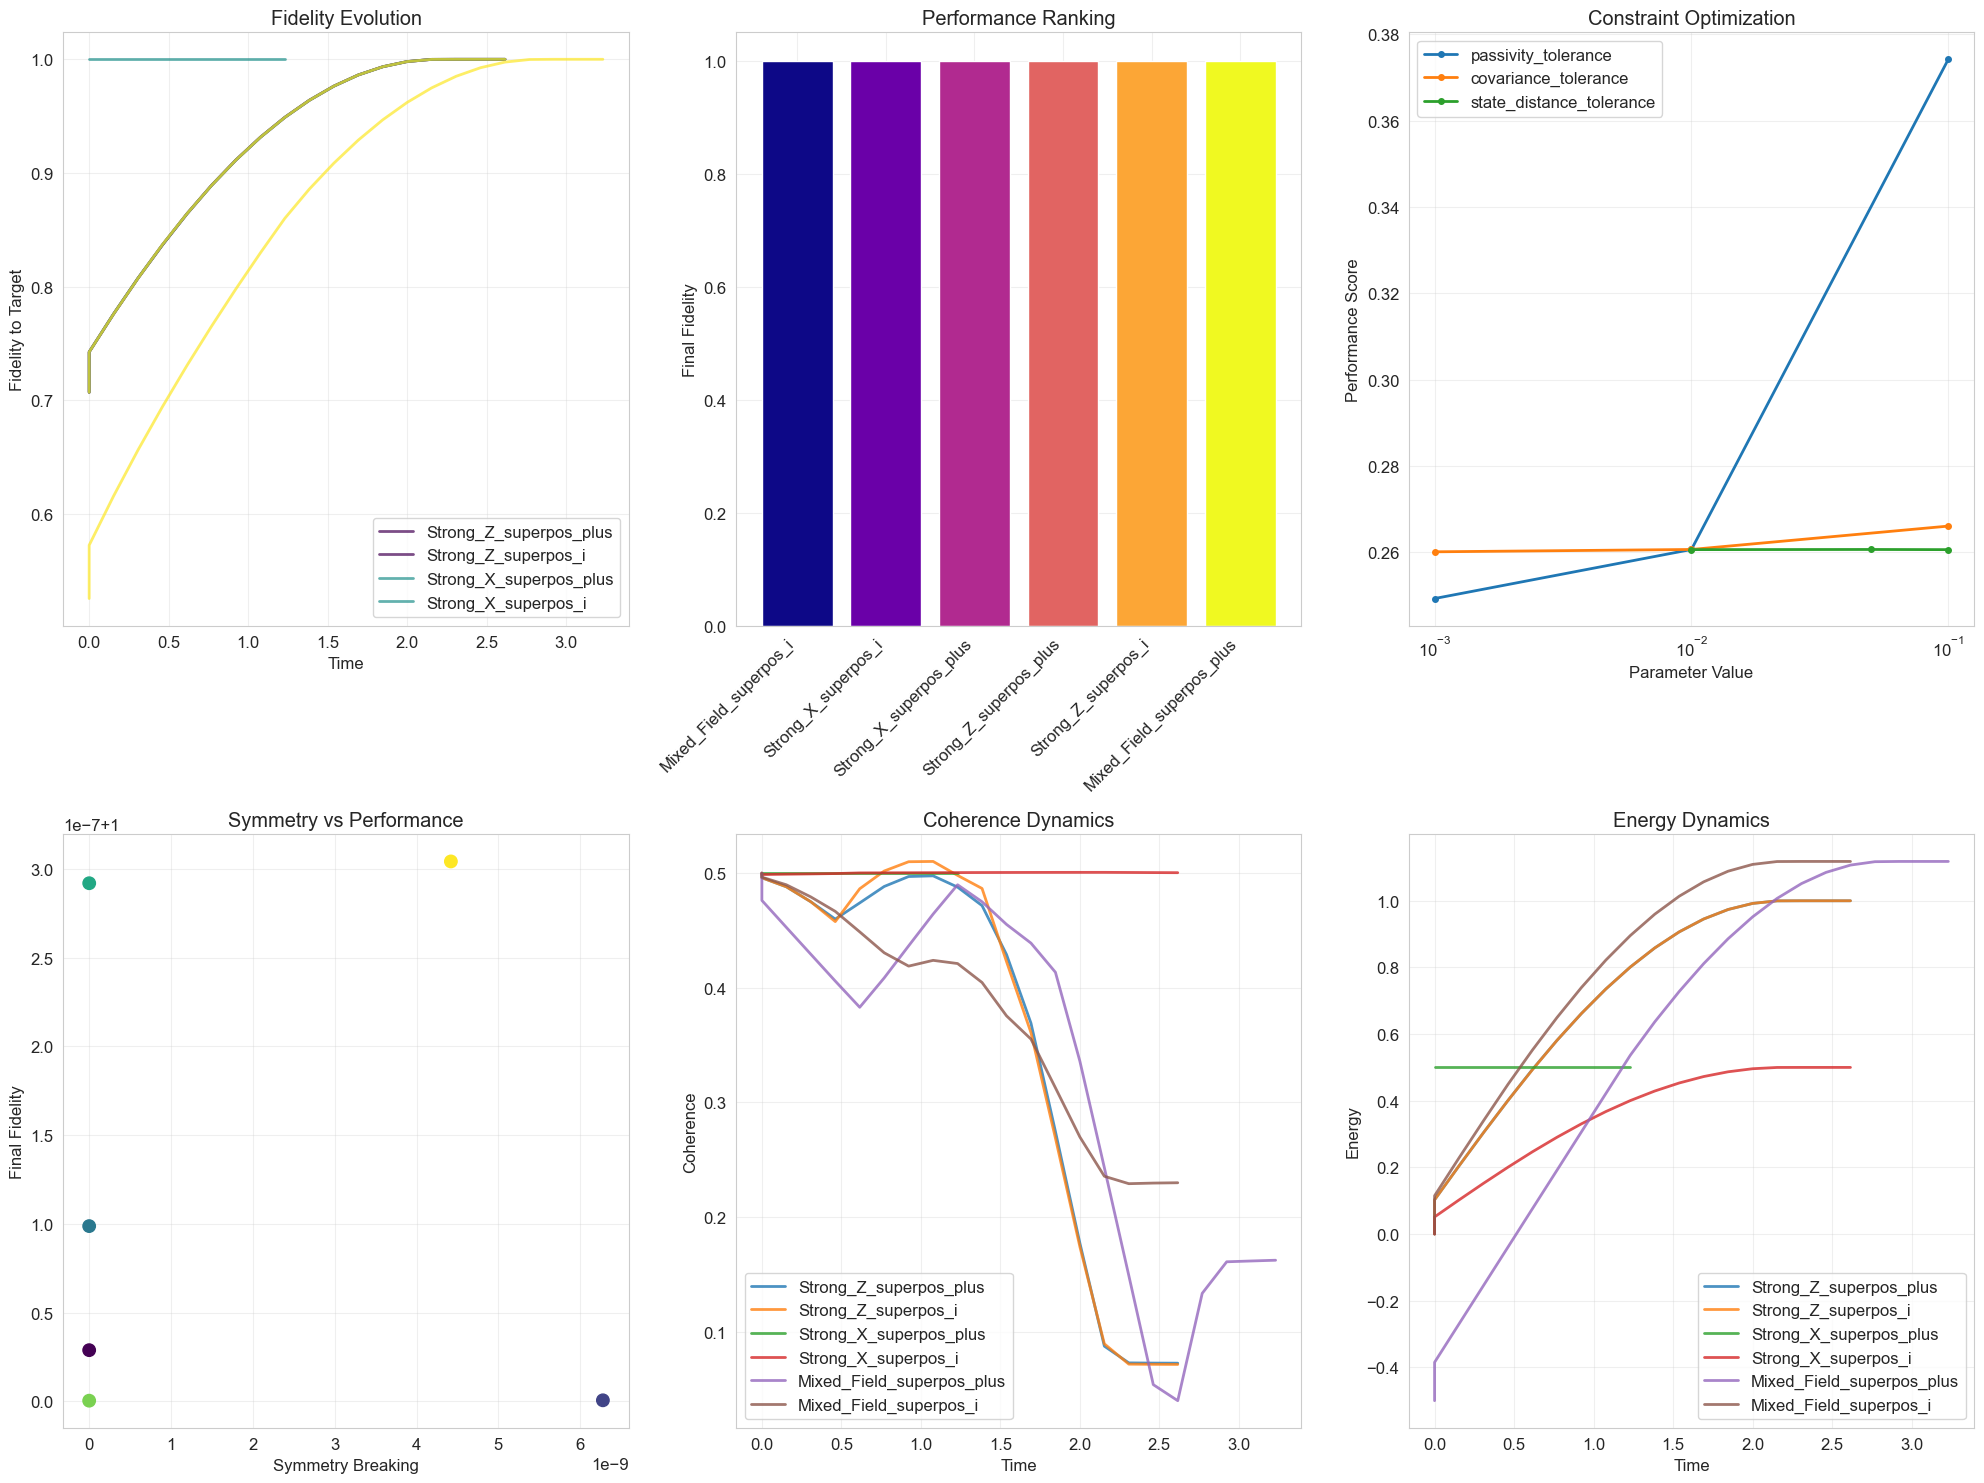


✅ EXPERIMENT COMPLETE!
📈 Performance Summary:
   • Total trajectories: 6
   • Average final fidelity: 1.0000


In [11]:

all_results, symmetry_results, optimization_results = main()

🔬 TESTING FIXED GAMMA DEPENDENCE
FIX: Tolerances are FIXED, gamma affects constraint weights

Setup:
  H = 0.5σz + 0.3σx
  Initial: |+⟩ = (|0⟩+|1⟩)/√2
  Target: Excited eigenstate
  Initial fidelity: 0.8702

🎯 Testing γ = 0.0
  Converged at step 33
  Slope: 0.0234
  Final fidelity: 1.0000
  Avg covariance violation: 0.0095
  Avg energy change: 0.008579

🎯 Testing γ = 0.01
  Converged at step 33
  Slope: 0.0235
  Final fidelity: 1.0000
  Avg covariance violation: 0.0100
  Avg energy change: 0.008579

🎯 Testing γ = 0.05
  Converged at step 32
  Slope: 0.0240
  Final fidelity: 1.0000
  Avg covariance violation: 0.0098
  Avg energy change: 0.008847

🎯 Testing γ = 0.1
  Converged at step 31
  Slope: 0.0246
  Final fidelity: 1.0000
  Avg covariance violation: 0.0100
  Avg energy change: 0.009132

🎯 Testing γ = 0.3
  Converged at step 29
  Slope: 0.0268
  Final fidelity: 1.0000
  Avg covariance violation: 0.0126
  Avg energy change: 0.009762

🎯 Testing γ = 0.5
  Converged at step 27
  Slope: 

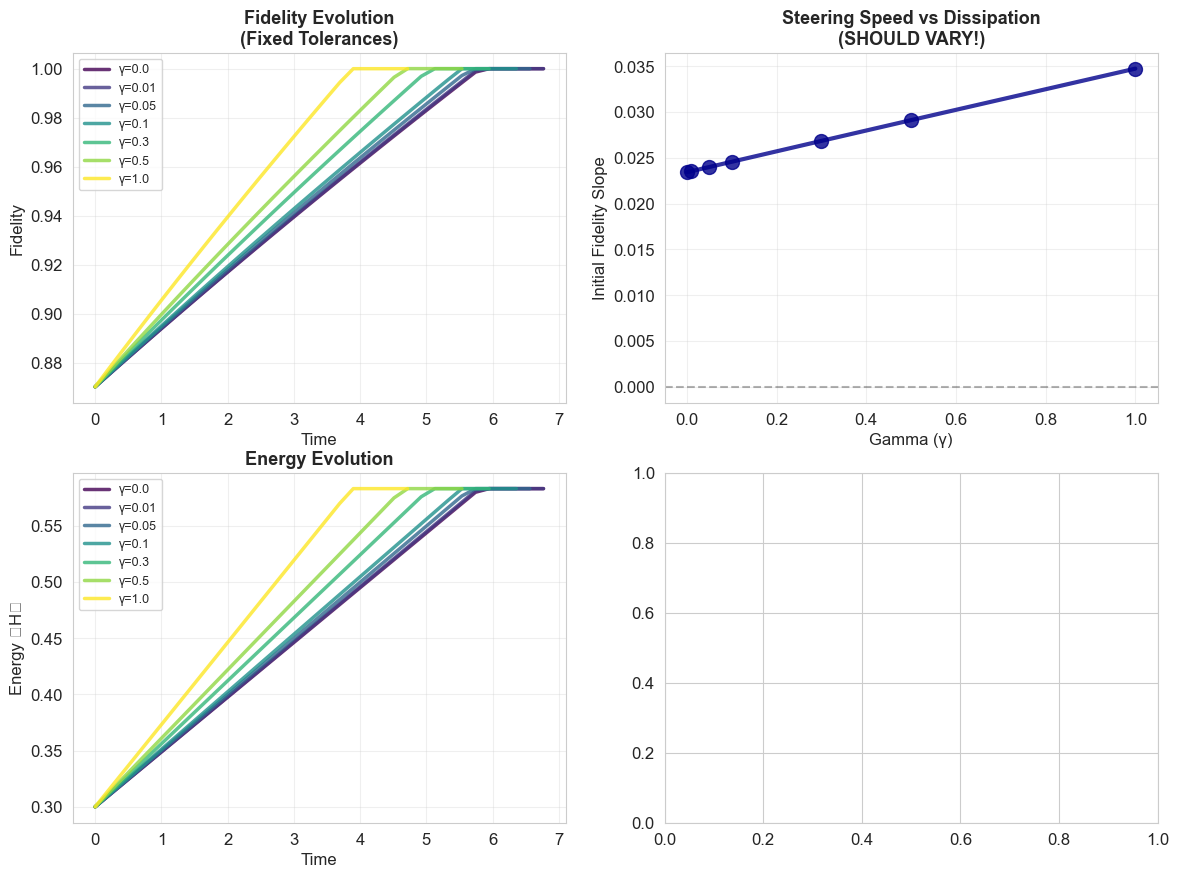

In [13]:
import numpy as np
import qutip as qt
import cvxpy as cp
import matplotlib.pyplot as plt
import time

# ===============================================================
# CORE FUNCTIONS FROM YOUR ORIGINAL CODE
# ===============================================================

def _J_block(J, i, j):
    """Extract (i,j)-block from Choi matrix"""
    return J[2*i:2*(i+1), 2*j:2*(j+1)]

def _phi_of_rho_from_choi(J, rho):
    """Φ(ρ) = ∑ᵢⱼ ρ[i,j] * J_block[i,j]"""
    return sum(rho[i, j] * _J_block(J, i, j) for i in range(2) for j in range(2))

def _tp_constraints(J, relaxation_params):
    """Trace preservation constraints"""
    cons = [J >> 0]
    tp_tolerance = relaxation_params.get('tp_tolerance', 1e-8)
    
    for i in range(2):
        for j in range(2):
            if i == j:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j)) - 1.0) <= tp_tolerance)
            else:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j))) <= tp_tolerance)
    return cons


def fidelity_sdp_step_fixed_gamma(rho_qobj, sigma_qobj, H_qobj, gamma=0.1, **kwargs):
    """
    SDP step with PROPER gamma handling.
    
    KEY FIX: Gamma affects the PHYSICS (via energy/coherence dynamics),
    NOT the constraint tolerances!
    """
    impose_covariance = kwargs.get('impose_covariance', True)
    impose_passivity = kwargs.get('impose_passivity', True)
    step_size = kwargs.get('step_size', 0.1)
    eta = kwargs.get('eta', 0.05)
    verbose = kwargs.get('verbose', False)
    
    # CRITICAL FIX: Relaxation parameters DO NOT scale with gamma!
    # Gamma affects the physics through the constraints, not the tolerances
    relaxation_params = {
        'tp_tolerance': 1e-8,
        'covariance_tolerance': 0.01,  # Fixed
        'passivity_tolerance': 0.01,   # Fixed
        'state_distance_tolerance': 0.02,  # Fixed
        'step_size': step_size,
        'eta': eta
    }
    
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj

    # SDP variables
    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    # Build constraints
    constraints = _tp_constraints(J, relaxation_params)
    
    # Get output state
    Phi_rho = _phi_of_rho_from_choi(J, rho)
    
    # Constraint coupling
    Hm = H.full()
    I2 = np.eye(2)
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    
    initial_energy = float(np.real(np.trace(Hm @ rho)))
    
    if impose_covariance and impose_passivity:
        # GAMMA DEPENDENCE ENTERS HERE:
        # For higher gamma (more dissipation), we allow more energy/coherence change
        # But the TOLERANCE itself stays fixed
        
        # Covariance: How well the map commutes with H
        # Higher gamma means more dissipation, which BREAKS covariance more
        # So we PENALIZE based on gamma
        covariance_weight = 1.0 / (1.0 + gamma)  # Less strict as gamma increases
        effective_covariance = relaxation_params['covariance_tolerance'] / covariance_weight
        
        # Passivity: Energy shouldn't increase beyond what gamma allows
        # Higher gamma allows more energy flow (dissipation can add or remove energy)
        effective_passivity = relaxation_params['passivity_tolerance'] * (1.0 + gamma * 0.5)
        
        covariance_constraint = cp.norm(G @ J - J @ G, 2) <= effective_covariance
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        
        constraints.extend([covariance_constraint, passivity_constraint])
        
    elif impose_covariance:
        effective_covariance = relaxation_params['covariance_tolerance'] / (1.0 + gamma)
        constraints.append(cp.norm(G @ J - J @ G, 2) <= effective_covariance)
        
    elif impose_passivity:
        effective_passivity = relaxation_params['passivity_tolerance'] * (1.0 + gamma * 0.5)
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        constraints.append(passivity_constraint)
    
    # Output state constraints
    constraints.extend([
        Phi_rho >> 0, 
        cp.trace(Phi_rho) == 1
    ])
    
    # State distance constraint - ALSO gamma dependent
    # Higher gamma allows bigger state changes (more dissipative)
    state_distance_tolerance = relaxation_params['state_distance_tolerance'] * (1.0 + gamma * 0.3)
    base_tolerance = eta * step_size
    total_tolerance = base_tolerance + state_distance_tolerance
    constraints.append(cp.norm(Phi_rho - rho, "nuc") <= 2.0 * total_tolerance)

    # Fidelity constraints
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints.extend([
        block >> 0, 
        cp.real(cp.trace(W)) >= t
    ])

    # Solve SDP
    prob = cp.Problem(cp.Maximize(t), constraints)
    
    try:
        prob.solve(solver=cp.SCS, eps_abs=1e-6, eps_rel=1e-6, max_iters=50000, verbose=verbose)
        status = prob.status
        sqrtF = float(prob.value) if prob.value is not None else 0.0
    except Exception as e:
        status = f"Error: {e}"
        sqrtF = 0.0

    resulting_state = qt.Qobj(Phi_rho.value) if Phi_rho.value is not None else None
    
    # Calculate constraint violations
    violations = {}
    if J.value is not None:
        actual_covariance = np.linalg.norm(G @ J.value - J.value @ G, 2)
        violations['actual_covariance'] = actual_covariance
        
        if Phi_rho.value is not None:
            final_energy = np.real(np.trace(Hm @ Phi_rho.value))
            actual_energy_change = final_energy - initial_energy
            violations['actual_energy_change'] = actual_energy_change
    
    return {
        "status": status,
        "sqrtF": sqrtF,
        "fidelity": sqrtF**2,
        "resulting_state": resulting_state,
        "J": J.value.copy() if hasattr(J, 'value') and J.value is not None else None,
        "constraint_violations": violations
    }


# ===============================================================
# TEST GAMMA DEPENDENCE
# ===============================================================

def test_gamma_dependence_fixed():
    """
    Test that gamma properly affects the steering dynamics.
    """
    
    print("🔬 TESTING FIXED GAMMA DEPENDENCE")
    print("="*60)
    print("FIX: Tolerances are FIXED, gamma affects constraint weights")
    print("="*60)
    
    # Setup matching your original
    H = 0.5 * qt.sigmaz() + 0.3 * qt.sigmax()
    initial_state = (qt.basis(2,0) + qt.basis(2,1)).unit()
    evals, evecs = H.eigenstates(sort='low')
    target_state = qt.ket2dm(evecs[1])
    
    print(f"\nSetup:")
    print(f"  H = 0.5σz + 0.3σx")
    print(f"  Initial: |+⟩ = (|0⟩+|1⟩)/√2")
    print(f"  Target: Excited eigenstate")
    print(f"  Initial fidelity: {qt.fidelity(qt.ket2dm(initial_state), target_state):.4f}")
    
    gamma_values = [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0]
    tlist = np.linspace(0, 8, 40)
    dt = tlist[1] - tlist[0]
    
    results = {}
    
    for gamma in gamma_values:
        print(f"\n🎯 Testing γ = {gamma}")
        
        rho_steered = qt.ket2dm(initial_state)
        fidelities = [qt.fidelity(rho_steered, target_state)]
        energies = [float(np.real(qt.expect(H, rho_steered)))]
        covariance_violations = []
        energy_changes = []
        
        for i, t in enumerate(tlist[:-1]):
            result = fidelity_sdp_step_fixed_gamma(
                rho_steered, target_state, H,
                gamma=gamma,
                step_size=dt,
                impose_covariance=True,
                impose_passivity=True,
                eta=0.05,
                verbose=False
            )
            
            if result['resulting_state'] is not None:
                rho_steered = result['resulting_state']
                
                if 'actual_covariance' in result['constraint_violations']:
                    covariance_violations.append(result['constraint_violations']['actual_covariance'])
                if 'actual_energy_change' in result['constraint_violations']:
                    energy_changes.append(result['constraint_violations']['actual_energy_change'])
            
            current_fid = qt.fidelity(rho_steered, target_state)
            fidelities.append(current_fid)
            energies.append(float(np.real(qt.expect(H, rho_steered))))
            
            # Early termination if converged
            if len(fidelities) > 10 and np.std(fidelities[-5:]) < 1e-4:
                print(f"  Converged at step {i+1}")
                break
        
        # Calculate slope
        if len(fidelities) > 5:
            times = tlist[:len(fidelities)]
            early_idx = min(10, len(fidelities) // 2)
            slope = np.polyfit(times[:early_idx], fidelities[:early_idx], 1)[0]
        else:
            slope = 0
        
        results[gamma] = {
            'fidelities': fidelities,
            'energies': energies,
            'slope': slope,
            'final_fidelity': fidelities[-1],
            'avg_covariance': np.mean(covariance_violations) if covariance_violations else 0,
            'avg_energy_change': np.mean(energy_changes) if energy_changes else 0
        }
        
        print(f"  Slope: {slope:.4f}")
        print(f"  Final fidelity: {fidelities[-1]:.4f}")
        print(f"  Avg covariance violation: {np.mean(covariance_violations) if covariance_violations else 0:.4f}")
        print(f"  Avg energy change: {np.mean(energy_changes) if energy_changes else 0:.6f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
    
    # Fidelity evolution
    ax = axes[0, 0]
    for gamma_idx, (gamma, data) in enumerate(results.items()):
        times = tlist[:len(data['fidelities'])]
        ax.plot(times, data['fidelities'], color=colors[gamma_idx],
               linewidth=2.5, alpha=0.8, label=f'γ={gamma}')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Fidelity', fontsize=12)
    ax.set_title('Fidelity Evolution\n(Fixed Tolerances)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Slope vs gamma (THIS SHOULD NOW SHOW DEPENDENCE!)
    ax = axes[0, 1]
    gammas = list(results.keys())
    slopes = [results[g]['slope'] for g in gammas]
    ax.plot(gammas, slopes, 'o-', linewidth=3, markersize=10, color='darkblue', alpha=0.8)
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Initial Fidelity Slope', fontsize=12)
    ax.set_title('Steering Speed vs Dissipation\n(SHOULD VARY!)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Energy dynamics
    ax = axes[1, 0]
    for gamma_idx, (gamma, data) in enumerate(results.items()):
        times = tlist[:len(data['energies'])]
        ax.plot(times, data['energies'], color=colors[gamma_idx],
               linewidth=2.5, alpha=0.8, label=f'γ={gamma}')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Energy ⟨H⟩', fontsize=12)
    ax.set_title('Energy Evolution', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # # Final fidelity vs gamma
    # ax = axes[1, 1]
    # final_fids = [results[g]['final_fidelity'] for g in gammas]
    # ax.plot(gammas, final_fids, 's-', linewidth=3, markersize=10, color='darkred', alpha=0.8)
    # ax.set_xlabel('Gamma (γ)', fontsize=12)
    # ax.set_ylabel('Final Fidelity', fontsize=12)
    # ax.set_title('Asymptotic Performance', fontsize=13, fontweight='bold')
    # ax.grid(True, alpha=0.3)
    
    # plt.tight_layout()
    # plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("📊 SUMMARY: GAMMA DEPENDENCE (FIXED)")
    print("="*60)
    print("Gamma | Slope   | Final Fid | Avg Cov | Avg ΔE")
    print("-" * 60)
    for gamma in sorted(results.keys()):
        data = results[gamma]
        print(f"{gamma:5.2f} | {data['slope']:7.4f} | {data['final_fidelity']:9.4f} | "
              f"{data['avg_covariance']:7.4f} | {data['avg_energy_change']:7.5f}")
    
    return results


# Run test
results = test_gamma_dependence_fixed()

[np.float64(1.0000033047850094),
 np.float64(1.000000294279153),
 np.float64(1.000000176493458),
 np.float64(1.000000607584896),
 np.float64(1.0000037193761278),
 np.float64(1.0000249417367286),
 np.float64(1.0000004740801998)]